In [102]:
import numpy as np
import pandas as pd
import random
import sklearn
import tensorflow as tf
import time
import warnings
import matplotlib.pyplot as plt

from keras.layers import Dropout
from keras.regularizers import l1, l2
from keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelBinarizer, label_binarize
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from xgboost import XGBClassifier


In [103]:
df_weekly_Spread = pd.read_excel(r"C:\Users\yhlim\Desktop\Spread Weekly.xlsx", sheet_name = 'Spread')
df_weekly_NFCI = pd.read_excel(r"C:\Users\yhlim\Desktop\Spread Weekly.xlsx", sheet_name = 'NFCI')
df_daily_VIX = pd.read_excel(r"C:\Users\yhlim\Desktop\Econ daily.xlsx", sheet_name = 'VIX')
df_daily_SP500 = pd.read_excel(r"C:\Users\yhlim\Desktop\Econ daily.xlsx",sheet_name = 'S&P')
df_daily_UST = pd.read_excel(r"C:\Users\yhlim\Desktop\Econ daily.xlsx",sheet_name = 'UST')

# Convert 'Date' columns to datetime
df_weekly_Spread['Date'] = pd.to_datetime(df_weekly_Spread['Date'])
df_weekly_NFCI['Date'] = pd.to_datetime(df_weekly_NFCI['Date'])

# Sort dataframes by 'Date'
df_weekly_Spread = df_weekly_Spread.sort_values('Date')
df_weekly_NFCI = df_weekly_NFCI.sort_values('Date')

# Perform the asof merge
df_merged_weekly = pd.merge_asof(df_weekly_Spread, df_weekly_NFCI, on='Date', direction='backward')

# Merge daily data with weekly data
df_final = pd.merge(df_merged_weekly, df_daily_VIX, on='Date', how='left')
df_final = pd.merge(df_final, df_daily_SP500, on='Date', how='left')
df_final = pd.merge(df_final, df_daily_UST, on='Date', how='left')

#drop the first 3 rows first because there's no complete month in January 
df_final = df_final.iloc[3:]
df_final['Rolling_SD'] = df_final['LN_Change'].rolling(window=4).std()
df_final['SD_Multiplier'] = df_final['LN_Change'] / df_final['Rolling_SD']
df_final['Market_State'] = 'Hold'
df_final.loc[df_final['SD_Multiplier'] > 1.5, 'Market_State']= "Widen"
df_final.loc[df_final['SD_Multiplier'] < -1.5, 'Market_State']= "Tighten"

df_final = df_final[['Date', 'Market_State','H0A0','Spread_Slope','IG_HYM','AAA_HYM','AA_HYM','A_HYM','BBB_HYM','T_5WkAAA','T_5WkAA','T_5WkA','T_5WkBBB','NFCI','VIX','Adj Close','Alpha 12','DGS3MO','DGS1','DGS2','DGS3','DGS5','DGS7','DGS10']]
df_final = df_final.dropna()


### Apply PCA on UST 

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select the columns for PCA
features_for_pca = df_final[['DGS3MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_pca)

# Perform PCA
pca = PCA(n_components=3)  # Choose the number of components that explain 95% of variance
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC_UST{i+1}' for i in range(principal_components.shape[1])])

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

# Ensure indices are aligned
df_final = df_final.reset_index(drop=True)
pca_df = pca_df.reset_index(drop=True)

# Add the PCA components to the main dataframe
df_final_pca = pd.concat([df_final, pca_df], axis=1)

# Optionally drop the original highly correlated columns
df_final_pca = df_final_pca.drop(columns=['DGS3MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10'])

Explained variance ratio: [0.94740981 0.04841384 0.00355834]


### Apply PCA on Trailing 5 week data

In [105]:
# Extract the spreads
spreads = df_final_pca[['T_5WkAAA', 'T_5WkAA', 'T_5WkA', 'T_5WkBBB']]

# Standardize the data
scaler = StandardScaler()
spreads_scaled = scaler.fit_transform(spreads)

# Apply PCA
pca = PCA(n_components=3)  # Choose the number of components you want
pca_components = pca.fit_transform(spreads_scaled)

# Create a DataFrame with PCA components
pca_df = pd.DataFrame(data=pca_components, columns=[f'PC_T5Wk{i+1}' for i in range(pca_components.shape[1])])
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')


# Combine PCA components with the original dataframe
df_final_pca = pd.concat([df_final_pca, pca_df], axis=1)

df_final_pca = df_final_pca.drop(columns=['T_5WkAAA', 'T_5WkAA', 'T_5WkA', 'T_5WkBBB'])


Explained variance ratio: [0.90047429 0.06455711 0.02338131]


### Apply PCA on IG_HYM/ AAA_HYM etc.

In [106]:
# Extract the spreads
spreads = df_final_pca[['H0A0','IG_HYM', 'AAA_HYM', 'AA_HYM', 'A_HYM', 'BBB_HYM']]

# Standardize the data
scaler = StandardScaler()
spreads_scaled = scaler.fit_transform(spreads)

# Apply PCA
pca = PCA(n_components=3)  # Choose the number of components you want
pca_components = pca.fit_transform(spreads_scaled)

# Create a DataFrame with PCA components
pca_df = pd.DataFrame(data=pca_components, columns=[f'PC_Diff{i+1}' for i in range(pca_components.shape[1])])

# Combine PCA components with the original dataframe
df_final_pca = pd.concat([df_final_pca, pca_df], axis=1)

df_final_pca = df_final_pca.drop(columns=['H0A0','IG_HYM', 'AAA_HYM', 'AA_HYM', 'A_HYM', 'BBB_HYM'])


#  Feature Importance Analysis

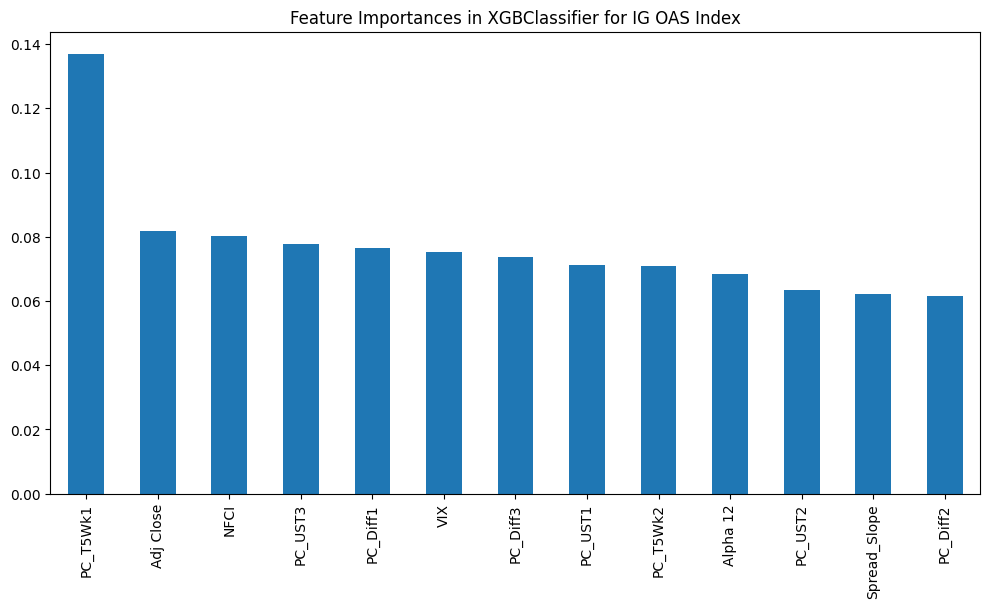

In [107]:

# Map labels from -1, 0, 1 to 0, 1, 2
label_mapping = {'Tighten': 0, 'Hold': 1, 'Widen': 2}

df_final_pca['Market_State'] = df_final_pca['Market_State'].map(label_mapping)

# Select features and label
data_features = df_final_pca[['Spread_Slope','NFCI','VIX','Adj Close','Alpha 12','PC_UST1','PC_UST2','PC_UST3','PC_T5Wk1','PC_T5Wk2','PC_Diff1','PC_Diff2','PC_Diff3']]
data_label = df_final_pca['Market_State']

# Initialize XGBClassifier with appropriate multi-class settings
xgb_clf = XGBClassifier(
    eval_metric='mlogloss',
    random_state=4,
    enable_categorical=True,
    objective='multi:softprob',  # Using probabilities for flexible post-processing
    num_class=3
)

# Fit the classifier to the training set
xgb_clf.fit(data_features, data_label)

# Get feature importances
feature_importances = xgb_clf.feature_importances_

# Create a pandas series with the feature importances
importances = pd.Series(feature_importances, index=data_features.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Plot the sorted feature importances
plt.figure(figsize=(12, 6))
sorted_importances.plot(kind='bar')
plt.title(f'Feature Importances in XGBClassifier for IG OAS Index')
plt.show()

# Optionally, revert labels in df for further analysis or use
#df_final_pca['Market_State'] = df_final_pca['Market_State'].map({v: k for k, v in label_mapping.items()})


# Comparative Analysis of Machine Learning Models

## 1.) `Logistic Regression`

c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


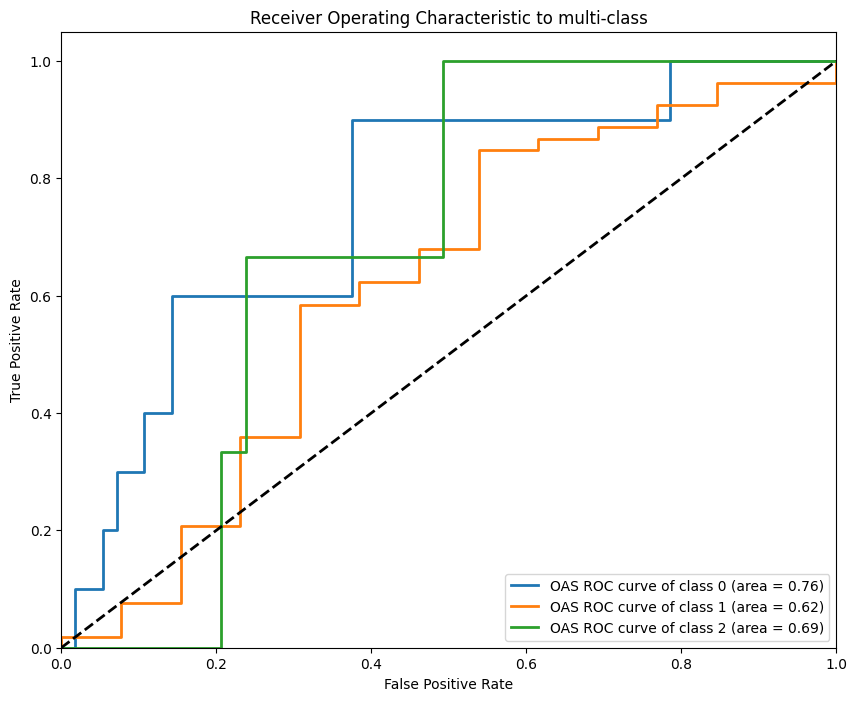

In [108]:
# Initialize a matplotlib figure for ROC curves
plt.figure(figsize=(10, 8))
split_date = '2023-01-09'
df_final_pca.set_index('Date', inplace = True) 
train_data = df_final_pca[df_final_pca.index < split_date]
test_data = df_final_pca[df_final_pca.index >= split_date]

X_train = train_data.drop(columns=['Market_State'])
y_train = train_data['Market_State']
X_test = test_data.drop(columns=['Market_State'])
y_test = test_data['Market_State']

# Create and train the multinomial logistic regression model
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Since the predict_proba gives us the probability for each class, we will use it to compute the ROC AUC
lb = LabelBinarizer()
lb.fit(y_train)
y_test_binarized = lb.transform(y_test)

# Predict probabilities for AUC-ROC
y_test_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_test_prob[:, i])

    # Modify the label to include the stock symbol
    plt.plot(fpr[i], tpr[i], lw=2, label=f'OAS ROC curve of class {class_label} (area = {roc_auc[i]:0.2f})')

# Plot all ROC curves
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [109]:

# Create and train the multinomial logistic regression model
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred_log = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_log)

# Transform labels for binary classification metrics calculation
lb = LabelBinarizer()
lb.fit(y_train)
y_test_binarized = lb.transform(y_test)
y_pred_binarized = lb.transform(y_pred_log)

# Predict probabilities for AUC-ROC
y_test_prob = model.predict_proba(X_test)

# Compute AUC-ROC - assuming binary classification or one-vs-rest for multi-class
auc_roc = roc_auc_score(y_test_binarized, y_test_prob, average='macro')

# Compute precision and recall - assuming average for multi-class
precision = precision_score(y_test, y_pred_log, average='macro')
recall = recall_score(y_test, y_pred_log, average='macro')

# Print the metrics for each stock
print(f"OAS: C0A0")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("-" * 30)

OAS: C0A0
Accuracy: 0.7879
AUC-ROC: 0.6862
Precision: 0.3810
Recall: 0.3541
------------------------------


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2.) `Neural Network`

In [110]:
# setting seed
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [111]:
set_seeds()

In [112]:
model1 = Sequential()
model1.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(3, activation='softmax'))  
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# One-hot encoding of the labels
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Fit the model with the encoded labels
model1.fit(X_train, y_train_encoded, epochs=10, verbose=False)


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
# Evaluate the model on the test set
accuracy = model1.evaluate(X_test, y_test_encoded, verbose=False)

print(f'Accuracy: {accuracy[1]}')


Accuracy: 0.3484848439693451


### Hyperparameter tuning: epochs, learing_rates, batch_sizes

In [114]:
# Define the model creation function with specific learning rate
def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Adjust input_dim to match feature count
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameter space
epochs = [5, 10, 15, 20, 25]
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
batch_sizes = [256, 512, 1024, 2048, 4096]

# Initialize best score and parameters
best_score = 0
best_params = {'epochs': None, 'learning_rate': None, 'batch_size': None}

# Hyperparameter tuning loop
for epoch in epochs:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Ensure the batch size is not larger than the number of training samples
            if batch_size > X_train.shape[0]:
                continue
            model = create_model(learning_rate=lr)
            try:
                model.fit(X_train, y_train_encoded, epochs=epoch, batch_size=batch_size, verbose=0)
                loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
                print(f"Epochs: {epoch}, Learning Rate: {lr}, Batch Size: {batch_size}, Accuracy: {accuracy:.4f}")

                # Update best score and parameters if current model is better
                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {
                        'epochs': epoch,
                        'learning_rate': lr,
                        'batch_size': batch_size
                    }
            except Exception as e:
                print(f"An error occurred: {e}")

# Output the best score and hyperparameters
print(f"Best Score: {best_score:.4f}")
print(f"Best Hyperparameters: {best_params}")

c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.0001, Batch Size: 256, Accuracy: 0.7727


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.0001, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.0001, Batch Size: 1024, Accuracy: 0.0606


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.0005, Batch Size: 256, Accuracy: 0.7879


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.0005, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.0005, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.001, Batch Size: 256, Accuracy: 0.1667


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.001, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.001, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.005, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.005, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.005, Batch Size: 1024, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.01, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.01, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 5, Learning Rate: 0.01, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.0001, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.0001, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.0001, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.0005, Batch Size: 256, Accuracy: 0.7879


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.0005, Batch Size: 512, Accuracy: 0.7576


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.0005, Batch Size: 1024, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.001, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.001, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.001, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.005, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.005, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.005, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.01, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.01, Batch Size: 512, Accuracy: 0.0455


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 10, Learning Rate: 0.01, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.0001, Batch Size: 256, Accuracy: 0.3030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.0001, Batch Size: 512, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.0001, Batch Size: 1024, Accuracy: 0.7879


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.0005, Batch Size: 256, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.0005, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.0005, Batch Size: 1024, Accuracy: 0.3485


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.001, Batch Size: 256, Accuracy: 0.5909


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.001, Batch Size: 512, Accuracy: 0.5000


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.001, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.005, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.005, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.005, Batch Size: 1024, Accuracy: 0.0455


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.01, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.01, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 15, Learning Rate: 0.01, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.0001, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.0001, Batch Size: 512, Accuracy: 0.5455


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.0001, Batch Size: 1024, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.0005, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.0005, Batch Size: 512, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.0005, Batch Size: 1024, Accuracy: 0.7121


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.001, Batch Size: 256, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.001, Batch Size: 512, Accuracy: 0.0455


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.001, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.005, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.005, Batch Size: 512, Accuracy: 0.0455


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.005, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.01, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.01, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 20, Learning Rate: 0.01, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.0001, Batch Size: 256, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.0001, Batch Size: 512, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.0001, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.0005, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.0005, Batch Size: 512, Accuracy: 0.7121


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.0005, Batch Size: 1024, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.001, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.001, Batch Size: 512, Accuracy: 0.0758


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.001, Batch Size: 1024, Accuracy: 0.1515


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.005, Batch Size: 256, Accuracy: 0.7576


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.005, Batch Size: 512, Accuracy: 0.1364


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.005, Batch Size: 1024, Accuracy: 0.7879


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.01, Batch Size: 256, Accuracy: 0.8030


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.01, Batch Size: 512, Accuracy: 0.7879


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epochs: 25, Learning Rate: 0.01, Batch Size: 1024, Accuracy: 0.8030
Best Score: 0.8030
Best Hyperparameters: {'epochs': 5, 'learning_rate': 0.0001, 'batch_size': 512}


In [115]:
# Pluggin the best combination of hyper parameter to the model
best_epochs = 5
best_learning_rate = 0.0001
best_batch_size = 512

# Create and compile the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# For AUC-ROC
auc_roc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class="ovr")

# For precision and recall, convert probabilities to class predictions
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test_encoded, axis=1)

# Calculating Precision and Recall for each class
precision = precision_score(y_true_class, y_pred_class, average='macro')
recall = recall_score(y_true_class, y_pred_class, average='macro')

# Printing the metrics
print(f"Accuracy: {accuracy[1]}")
print(f"AUC-ROC: {auc_roc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1322 - loss: 143.1924
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1322 - loss: 135.6552 
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1322 - loss: 128.0666 
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1322 - loss: 120.4732 
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1322 - loss: 112.9043 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Accuracy: 0.04545454680919647
AUC-ROC: 0.5
Precision: 0.015151515151515152
Recall: 0.3333333333333333


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Dropout Regularization

In [116]:
set_seeds()

we try the number of dropout rate as 0.1 ,0.2, 0.3, 0.4, and 0.5. And 0.5 yield the best result so we will use this number as a dropout rate.

In [117]:

# Create and compile the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.5, seed=100))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5, seed=100))
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=0.5, seed=100))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# For AUC-ROC
auc_roc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class="ovr")

# For precision and recall, convert probabilities to class predictions
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test_encoded, axis=1)

# Calculating Precision and Recall for each class
precision = precision_score(y_true_class, y_pred_class, average='macro')
recall = recall_score(y_true_class, y_pred_class, average='macro')

# Printing the metrics
print(f"Accuracy: {accuracy[1]}")
print(f"AUC-ROC: {auc_roc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3317 - loss: 384.7299
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3627 - loss: 345.2651 
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3654 - loss: 361.5672 
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3319 - loss: 344.6287 
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3489 - loss: 367.5711 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.04545454680919647
AUC-ROC: 0.452849386811651
Precision: 0.015151515151515152
Recall: 0.3333333333333333


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### L1 Regularization

In [118]:
set_seeds()

In [119]:
# Create and compile the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', activity_regularizer=l1(0.0001)))
model.add(Dense(32, activation='relu', activity_regularizer=l1(0.0001)))
model.add(Dense(16, activation='relu', activity_regularizer=l1(0.0001)))
model.add(Dense(3, activation='softmax', activity_regularizer=l1(0.0001)))
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# For AUC-ROC
auc_roc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class="ovr")

# For precision and recall, convert probabilities to class predictions
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test_encoded, axis=1)

# Calculating Precision and Recall for each class
precision = precision_score(y_true_class, y_pred_class, average='macro')
recall = recall_score(y_true_class, y_pred_class, average='macro')

# Printing the metrics
print(f"Accuracy: {accuracy[1]}")
print(f"AUC-ROC: {auc_roc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Epoch 1/5


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1322 - loss: 706.6448
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1322 - loss: 692.7672  
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1327 - loss: 678.8763 
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4242 - loss: 667.1868 
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 664.9839 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy: 0.8030303120613098
AUC-ROC: 0.5202821869488536
Precision: 0.2676767676767677
Recall: 0.3333333333333333


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### L2 Regularization

In [120]:
# Create and compile the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', activity_regularizer=l2(0.0005)))
model.add(Dense(32, activation='relu', activity_regularizer=l2(0.0005)))
model.add(Dense(16, activation='relu', activity_regularizer=l2(0.0005)))
model.add(Dense(3, activation='softmax', activity_regularizer=l2(0.0005)))
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# For AUC-ROC
auc_roc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class="ovr")

# For precision and recall, convert probabilities to class predictions
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test_encoded, axis=1)

# Calculating Precision and Recall for each class
precision = precision_score(y_true_class, y_pred_class, average='macro')
recall = recall_score(y_true_class, y_pred_class, average='macro')

# Printing the metrics
print(f"Accuracy: {accuracy[1]}")
print(f"AUC-ROC: {auc_roc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Epoch 1/5


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7175 - loss: 1261839.2500
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7175 - loss: 1249346.0000 
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7175 - loss: 1237384.1250 
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7175 - loss: 1225647.2500 
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7175 - loss: 1214094.5000 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy: 0.8030303120613098
AUC-ROC: 0.5571428571428572
Precision: 0.2676767676767677
Recall: 0.3333333333333333


c:\Users\yhlim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##  3.) `XgBoost`

Tuning hyper parameter using `GridSearchCV`

In [121]:
# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 7]
}

# Create the scorers dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='macro'),  # Ensure multiclass handling
    'roc_auc': 'roc_auc_ovr'  # Use One-vs-Rest approach for multiclass AUC
}

# Create the XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss')

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scoring, refit='roc_auc', cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(data_features, data_label)

# View the results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']]

Fitting 3 folds for each of 125 candidates, totalling 375 fits


,params,mean_test_accuracy,mean_test_f1,mean_test_roc_auc
0,"{'eta': 0.01, 'max_depth': 3, 'n_estimators': 50}",0.716214,0.281479,0.604866
1,"{'eta': 0.01, 'max_depth': 3, 'n_estimators': ...",0.716214,0.284551,0.606221
2,"{'eta': 0.01, 'max_depth': 3, 'n_estimators': ...",0.708272,0.297580,0.605433
3,"{'eta': 0.01, 'max_depth': 3, 'n_estimators': ...",0.706679,0.299170,0.608874
4,"{'eta': 0.01, 'max_depth': 3, 'n_estimators': ...",0.704296,0.298240,0.607660
...,...,...,...,...
120,"{'eta': 0.2, 'max_depth': 7, 'n_estimators': 50}",0.617652,0.328437,0.575986
121,"{'eta': 0.2, 'max_depth': 7, 'n_estimators': 100}",0.620832,0.341824,0.569869
122,"{'eta': 0.2, 'max_depth': 7, 'n_estimators': 150}",0.622417,0.351491,0.568779
123,"{'eta': 0.2, 'max_depth': 7, 'n_estimators': 200}",0.620830,0.349871,0.568782


In [122]:
# Normalize the scores to make them comparable
cv_results['normalized_accuracy'] = cv_results['mean_test_accuracy'] / cv_results['mean_test_accuracy'].max()
cv_results['normalized_f1'] = cv_results['mean_test_f1'] / cv_results['mean_test_f1'].max()
cv_results['normalized_roc_auc'] = cv_results['mean_test_roc_auc'] / cv_results['mean_test_roc_auc'].max()

# Calculate the average of the normalized scores
cv_results['average_score'] = cv_results[['normalized_accuracy', 'normalized_f1', 'normalized_roc_auc']].mean(axis=1)

# Sort the DataFrame based on the average score in descending order
cv_results_sorted = cv_results.sort_values('average_score', ascending=False)

# The first row will now be the combination of parameters with the highest average normalized score
best_combination_row = cv_results_sorted.iloc[0]

# Extract the best scores and parameters
best_parameters = best_combination_row['params']
best_accuracy = best_combination_row['mean_test_accuracy']
best_f1 = best_combination_row['mean_test_f1']
best_roc_auc = best_combination_row['mean_test_roc_auc']
best_average_score = best_combination_row['average_score']

print(f"Best parameters: {best_parameters}")
print(f"Accuracy: {best_accuracy}")
print(f"F1 Score: {best_f1}")
print(f"ROC-AUC Score: {best_roc_auc}")
print(f"Best Average Normalized Score: {best_average_score}")

Best parameters: {'eta': 0.2, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.641483880744024
F1 Score: 0.3699886514437248
ROC-AUC Score: 0.5755091789427426
Best Average Normalized Score: 0.9458785673357332


In [123]:
# Best Parameter from GridSearch
best_eta = 0.05
best_n_estimators = 100
best_max_depth = 3

# Lists to store metrics
lst_auc_roc_gridsearch = []
lst_precision_gridsearch = []
lst_recall_gridsearch = []
lst_accuracy_gridsearch = []


# Applying the best parameters found by GridSearchCV
model = XGBClassifier(eval_metric='logloss', eta=best_eta, n_estimators=best_n_estimators, max_depth= best_max_depth)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred_xgb = model.predict(X_test)

# Calculate metrics
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
precision = precision_score(y_test, y_pred_xgb, average='macro')
recall = recall_score(y_test, y_pred_xgb, average='macro')
accuracy = accuracy_score(y_test, y_pred_xgb)

lst_auc_roc_gridsearch.append(auc_roc)
lst_precision_gridsearch.append(precision)
lst_recall_gridsearch.append(recall)
lst_accuracy_gridsearch.append(accuracy)

# Calculating averages
avg_auc_roc = np.mean(lst_auc_roc_gridsearch)
avg_precision = np.mean(lst_precision_gridsearch)
avg_recall = np.mean(lst_recall_gridsearch)
avg_accuracy = np.mean(lst_accuracy_gridsearch)

# Creating a DataFrame with the average results
avg_results_df = pd.DataFrame({
    'AUC-ROC': [avg_auc_roc],
    'Precision': [avg_precision],
    'Recall': [avg_recall],
    'Accuracy': [avg_accuracy]
}, index=['Average Scoring Metrics'])

# Display the average results DataFrame
print(avg_results_df)

                         AUC-ROC  Precision    Recall  Accuracy
Average Scoring Metrics  0.46501   0.263441  0.308176  0.742424


# Conclusion

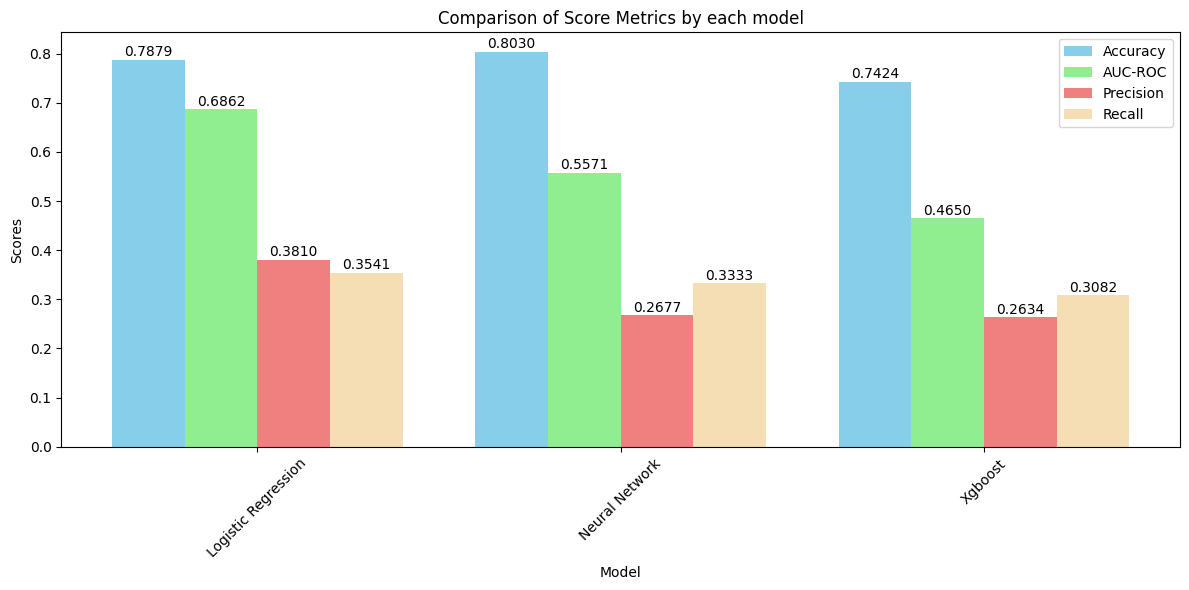

In [124]:
# Define the architectures and their metrics
archs = ['Logistic Regression', 'Neural Network', 'Xgboost']  # Corrected the typo and quotes
accuracies = [0.7879, 0.8030303120613098,0.742424]
auc_roc = [0.6862,  0.5571428571428572,0.46501]
precisions = [0.3810, 0.2676767676767677, 0.263441]
recalls = [0.3541,  0.33333, 0.308176]


# Create a DataFrame
df = pd.DataFrame({'Accuracy': accuracies, 'AUC-ROC': auc_roc, 'Precision': precisions, 'Recall': recalls}, index=archs)

# Plotting
bar_width = 0.2
index = np.arange(len(archs))

plt.figure(figsize=(12, 6))

bars1 = plt.bar(index, df['Accuracy'], bar_width, label='Accuracy', color='skyblue')
bars2 = plt.bar(index + bar_width, df['AUC-ROC'], bar_width, label='AUC-ROC', color='lightgreen')
bars3 = plt.bar(index + 2 * bar_width, df['Precision'], bar_width, label='Precision', color='lightcoral')
bars4 = plt.bar(index + 3 * bar_width, df['Recall'], bar_width, label='Recall', color='wheat')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Score Metrics by each model')
plt.xticks(index + 1.5 * bar_width, archs, rotation=45)
plt.legend()

# Adding numbers on top of each bar
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., 1.002 * height, f'{height:.4f}', ha='center', va='bottom')

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)

plt.tight_layout()
plt.show()


### Trading

In [125]:
df_return = pd.read_excel(r"C:\Users\yhlim\Desktop\C0A0price for y_test.xlsx")
filter_weekly = pd.merge(df_final, df_return, on='Date',how='inner')
filter_weekly = filter_weekly[['Date','IndexPrice']]
filter_weekly.set_index('Date', inplace=True)
filter_weekly['y_pred_log'] = y_pred_log[:len(filter_weekly)]
filter_weekly['y_pred_class'] = y_pred_class[:len(filter_weekly)]
filter_weekly['y_pred_xgb'] = y_pred_xgb[:len(filter_weekly)]

### Performance for Logistic Regression

In [126]:
# Initialize variables
initial_investment = 1
investment = initial_investment
cumulative_return = 1
previous_price = None

# Lists to track results
returns = []
cumulative_returns = []

# Apply the strategy
for i in range(len(filter_weekly)-1):
    row = filter_weekly.iloc[i]
    price = row['IndexPrice']
    signal = row['y_pred_log']
    
    if i < len(filter_weekly) - 1:
        next_price = filter_weekly['IndexPrice'].iloc[i+1]
        if signal == 0:  # Buy
            weekly_return = (next_price - price) / price
            returns.append(weekly_return)
            cumulative_return *= (1 + weekly_return)
            investment = cumulative_return
        elif signal == 1:  # Hold
            returns.append(0)
        elif signal == 2:  # Sell
            if i < len(filter_weekly) - 1:  # Ensure there's a next week to recover
                next_price = filter_weekly['IndexPrice'].iloc[i + 1]
                weekly_return = (price - next_price) / next_price
                returns.append(weekly_return)
                cumulative_return *= (1 + weekly_return)
                investment = cumulative_return
            else:
                returns.append(0)  # If no next week, no action possible
        else:
            raise ValueError("Unknown signal value")

    cumulative_returns.append(cumulative_return)

filter_weekly = filter_weekly[:-1]
filter_weekly['CumulativeReturn_Log'] = cumulative_returns

### Performance for Neural Network 

In [127]:
# Initialize variables
initial_investment = 1
investment = initial_investment
cumulative_return = 1
previous_price = None
returns = []
cumulative_returns = []

    # Apply the strategy
for i in range(len(filter_weekly)-1):
    row = filter_weekly.iloc[i]
    price = row['IndexPrice']
    signal = row['y_pred_class']
    
    if i < len(filter_weekly) - 1:
        next_price = filter_weekly['IndexPrice'].iloc[i+1]
        if signal == 0:  # Buy
            weekly_return = (next_price - price) / price
            returns.append(weekly_return)
            cumulative_return *= (1 + weekly_return)
            investment = cumulative_return
        elif signal == 1:  # Hold
            returns.append(0)
        elif signal == 2:  # Sell
            if i < len(filter_weekly) - 1:  # Ensure there's a next week to recover
                next_price = filter_weekly['IndexPrice'].iloc[i + 1]
                weekly_return = (price - next_price) / next_price
                returns.append(weekly_return)
                cumulative_return *= (1 + weekly_return)
                investment = cumulative_return
            else:
                returns.append(0)  # If no next week, no action possible
        else:
            raise ValueError("Unknown signal value")

    cumulative_returns.append(cumulative_return)

# Add cumulative returns to the DataFrame
filter_weekly = filter_weekly[:-1]
filter_weekly['CumulativeReturn_RF'] = cumulative_returns

### Performance for Xgboost 

In [128]:
# Initialize variables
initial_investment = 1
investment = initial_investment
cumulative_return = 1
previous_price = None
returns = []
cumulative_returns = []

    # Apply the strategy
for i in range(len(filter_weekly)-1):
    row = filter_weekly.iloc[i]
    price = row['IndexPrice']
    signal = row['y_pred_xgb']
    
    if i < len(filter_weekly) - 1:
        next_price = filter_weekly['IndexPrice'].iloc[i+1]
        if signal == 0:  # Buy
            weekly_return = (next_price - price) / price
            returns.append(weekly_return)
            cumulative_return *= (1 + weekly_return)
            investment = cumulative_return
        elif signal == 1:  # Hold
            returns.append(0)
        elif signal == 2:  # Sell
            if i < len(filter_weekly) - 1:  # Ensure there's a next week to recover
                next_price = filter_weekly['IndexPrice'].iloc[i + 1]
                weekly_return = (price - next_price) / next_price
                returns.append(weekly_return)
                cumulative_return *= (1 + weekly_return)
                investment = cumulative_return
            else:
                returns.append(0)  # If no next week, no action possible
        else:
            raise ValueError("Unknown signal value")

    cumulative_returns.append(cumulative_return)

# Add cumulative returns to the DataFrame
filter_weekly = filter_weekly[:-1]
filter_weekly['CumulativeReturn_xgb'] = cumulative_returns


In [129]:
filter_weekly['Actual'] = y_test

C0A0 price can be obtained by summing (weight of bonds * price of bonds in C0A0), and thus we are able to get the IndexPrice everyday from 1/3/2022 to 15/7/2024, the cumulative return one can receive by investing in the Index is invest it on 1/3/2022 and selling it on 15/72024 which gives cumulative return of 0.03513439. Alternatively, one can implement this strategy - 
1.Buy and hold for a week for the next signal if y_pred is 0 (Tighten)
2.Hold for a week if y_pred is 1 (Hold)
3.Sell and wait for the next signal if y_pred is 2 (Widen)